## Fit data using GLLS in SAMMY

This notebook works to shows how the sammy interface module of ATARI can be used to fit data with SAMMY

In [11]:
from matplotlib.pyplot import *
import numpy as np
import pandas as pd
import os
from dataclasses import asdict
from copy import copy

from ATARI.syndat.particle_pair import Particle_Pair
from ATARI.syndat.experiment import Experiment
from ATARI.theory.resonance_statistics import make_res_par_avg
from ATARI.sammy_interface import sammy_classes, sammy_functions

import importlib


In [12]:
%matplotlib widget

# First, setup/generate synthetic data using SAMMY

#### Define physical values, experiment, and resonance ladder

In [13]:
ac = 0.81271  # scattering radius in 1e-12 cm 
M = 180.948030  # amu of target nucleus
m = 1           # amu of incident neutron
I = 3.5         # intrinsic spin, positive parity
i = 0.5         # intrinsic spin, positive parity
l_max = 1       # highest order l-wave to consider

Elam = 50.0
E_min_max = [np.max([Elam-20, 1.0]), Elam+20]
energy_grid = np.linspace(min(E_min_max), max(E_min_max), 1000)

# for Gg_DOF in [10,50,100,1000,10000]:
Gg_DOF = 10

from ATARI.theory import scattering_params
shift, penetration, phi, k = scattering_params.FofE_explicit([1,500], ac, M, m, 0)
res_par_avg = make_res_par_avg(D_avg = 8.79, 
                            Gn_avg= np.mean(penetration)*2*46.4, #0.658, 
                            n_dof = 1, 
                            Gg_avg = 64.0, 
                            g_dof = Gg_DOF, 
                            print = False)


spin_groups = [ (3.0,1,0) ]
average_parameters = {'3.0':res_par_avg}

Ta_pair = Particle_Pair( ac, M, m, I, i, l_max,
                                input_options={},
                                spin_groups=spin_groups,
                                average_parameters=average_parameters )   
# resonance_ladder = Ta_pair.sample_resonance_ladder(energy_grid, spin_groups, average_parameters)
resonance_ladder = pd.DataFrame({"E":[31.8030900, 43.3031830, 56.0645210],
                                 "Gg":[54.9451300, 59.7455500, 86.1347900],
                                 "Gn":[0.3913400, 2.9012500, 2.1717400],
                                 "J":[ 3,3,3,], "chs":[1,1,1,], "lwave":[0,0,0], "J_ID":[1,1,1]})
# resonance_ladder = pd.DataFrame({'E':[80.0], 'Gt':[16], 'Gn':[1], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
# resonance_ladder = pd.DataFrame({'E':[4.0], 'Gg':[7.0], 'Gn':[4.0], 'J':[3], 'chs':[1], 'lwave':[0], 'J_ID':[1]})
resonance_ladder

,E,Gg,Gn,J,chs,lwave,J_ID
0,31.803090,54.94513,0.39134,3,1,0,1
1,43.303183,59.74555,2.90125,3,1,0,1
2,56.064521,86.13479,2.17174,3,1,0,1


In [34]:
importlib.reload(sammy_classes)
importlib.reload(sammy_functions)

sammyRTO = sammy_classes.SammyRunTimeOptions(
    path_to_SAMMY_exe = '/Users/noahwalton/gitlab/sammy/sammy/build/bin/sammy',
    model = 'SLBW',
    reaction = 'total',
    solve_bayes = False,
    inptemplate = "/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp", #"allexptot_1sg.inp",
    inpname = "sammy.inp",
    energy_window = None,
    sammy_runDIR = 'SAMMY_runDIR',
    keep_runDIR = False,
    shell = 'zsh'
    )

sammyINP = sammy_classes.SammyInputData(
    particle_pair = Ta_pair,
    resonance_ladder = resonance_ladder,
    energy_grid = energy_grid,
    temp = 304.5,
    FP=35.185,
    frac_res_FP=0.049600,
    target_thickness=0.067166)

sammyOUT = sammy_functions.run_sammy(sammyINP, sammyRTO)

unc_scale = 0.05
trans = pd.DataFrame({'E': energy_grid})
# trans["exp"] = sammyOUT.pw["theo_trans"] #np.random.default_rng().normal(sammyOUT.pw["theo_trans"], np.sqrt(sammyOUT.pw["theo_trans"])*unc_scale )
trans["exp"] = abs(np.random.default_rng().normal(sammyOUT.pw["theo_trans"], np.sqrt(sammyOUT.pw["theo_trans"])*unc_scale ))
trans["exp_unc"] = np.sqrt(trans["exp"])*unc_scale

estladder = copy(resonance_ladder)
estladder[["Gg", "Gn1"]] = estladder[["Gg", "Gn1"]]*0.01
# estladder["E"] = estladder["E"] + 10

sammyRTO.solve_bayes = True
sammyRTO.reaction = 'transmission'
sammyRTO.keep_runDIR = True
sammyRTO.recursive = True
sammyRTO.recursive_opt = {"threshold":0.01,
                            "iterations": 20,
                            "print":True}

sammyINP.experimental_data = trans
sammyINP.resonance_ladder = estladder
sammyINP.initial_parameter_uncertainty = 0.01

sammyOUT_fit = sammy_functions.run_sammy(sammyINP, sammyRTO)


2049.243074687465
1149.525686757921
1867.5503281706806
1971.0617629859917
1002.9628711785608
146.74317914193853
135.51794433633404
1115.5685920750602
115.83809727302469
51.177190865440934
66.90682439530428
37.52533661197049
18.310663803460557
20.32194151130534
349.1516179200444
244.10152582393948
206.32217704328832
21.02856388782675
-1.9627415333770841


In [35]:
print(sammyOUT_fit.par)
print(sammyOUT_fit.par_post)
print(resonance_ladder)

           E        Gg       Gn1  J  chs  lwave  J_ID
0  31.803090  0.549451  0.003913  3    1      0     1
1  43.303183  0.597456  0.029013  3    1      0     1
2  56.064521  0.861348  0.021717  3    1      0     1
           E          Gg       Gn1  varyE  varyGg  varyGn1  J_ID
0  31.065092    0.549570  0.003968    1.0     1.0      1.0   1.0
1  43.308828  172.805993  1.704210    1.0     1.0      1.0   1.0
2  56.065362    0.827344  1.556587    1.0     1.0      1.0   1.0
           E        Gg      Gn1  J  chs  lwave  J_ID
0  31.803090  54.94513  0.39134  3    1      0     1
1  43.303183  59.74555  2.90125  3    1      0     1
2  56.064521  86.13479  2.17174  3    1      0     1


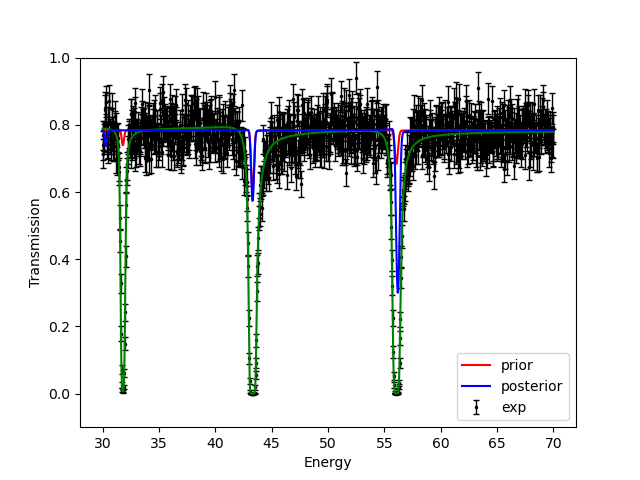

In [37]:
figure()
plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, 'g')
plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans, ms=1, color='r', label='prior')
plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans_bayes, ms=1, color='b', label='posterior')
errorbar(trans.E, trans.exp, yerr=trans.exp_unc, zorder=0, 
                                        fmt='.', color='k', linewidth=1, markersize=3, capsize=2, label='exp')

ylim([-.1, 1])
# xscale('log')
xlabel('Energy'); ylabel('Transmission')
legend()


#### Method for doing least squares with sammy in

In [41]:
sammyRTO.sammy_runDIR = "/Users/noahwalton/Documents/GitHub/ATARI/examples/SAMMY_runDIR_ls"
sammyRTO.keep_runDIR = True
iterations = 3
steps = 50

datasets = [trans]
dataset_titles = ["trans1"]
reactions = ["transmission"]
templates = ["/Users/noahwalton/Documents/GitHub/ATARI/ATARI/sammy_interface/sammy_templates/allexptot_1sg.inp"]
# templates = ["/Users/noahwalton/Documents/GitHub/ATARI/examples/sammy_template.inp"]


sammy_functions.setup_YW_scheme(sammyRTO, sammyINP, datasets, dataset_titles, reactions, templates, 
                                                                                steps=steps,
                                                                                iterations=iterations)

os.system(f"chmod +x {os.path.join(sammyRTO.sammy_runDIR, 'iterate.zsh')}")
os.system(f"chmod +x {os.path.join(sammyRTO.sammy_runDIR, 'run.zsh')}")

0

In [8]:
# os.system(os.path.join(sammyRTO.sammy_runDIR, 'run.zsh'))

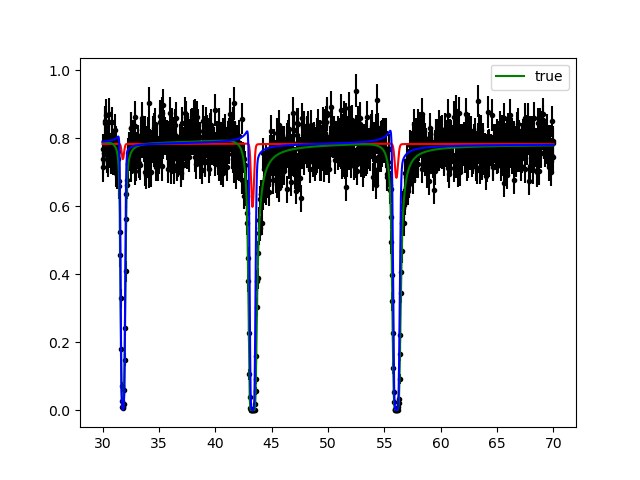

In [42]:
### Read results

T0 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,"results/trans1_step0.lst"))
T1 = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{steps}.lst"))
# test = sammy_functions.readlst(os.path.join(simdir,"SAMMY.LST"))

figure()
plot(T0.E, T0.theo_trans, 'r')
plot(sammyOUT.pw.E, sammyOUT.pw.theo_trans, ms=1, color='g', label='true')

plot(T1.E, T1.theo_trans, 'b')

# plot(itertrans.E, itertrans.theo_trans, 'pink')
# plot(test.E, test.theo_trans, 'pink')
# plot(test1.E, test1.theo_trans, 'purple')
# plot(sammyOUT_fit.pw.E, sammyOUT_fit.pw.theo_trans_bayes, ms=1, color='pink', label='posterior')

errorbar(T1.E, T1.exp_trans, yerr=T1.exp_trans_unc, color='k', fmt='.', zorder=0)


# for i in range(1,steps+1):
#     lst = sammy_functions.readlst(os.path.join(sammyRTO.sammy_runDIR,f"results/trans1_step{i}.lst"))
#     plot(lst.E, lst.theo_trans, label=i)

legend()